# ДЗ № 8
Краевая задача для ОДУ второго порядка (метод Ритца)

Ниже решение данного уравнения:
$-\left(\frac{2+x}{3+x}u'\right)' + (1+sin(x))u=1-x$

с краевыми условиями:
$u'(-1) = 0$
$u'(1) + u(1) = 0$

с координатной системой:
$1, x, (1-x^2)P^{1,1}_{i}(x)$, где $i=0,1,...$

In [17]:
from typing import Callable, Union, List

import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial import polynomial as P
import seaborn as sns
from functools import lru_cache
from scipy import integrate
from tqdm import tqdm, trange

In [3]:
SimpleFunction = Callable[[float], float]

In [4]:
def p(x: float) -> float:
    return (2 + x) / (3 + x)


def r(x: float) -> float:
    return 1 + np.sin(x)


def f(x: float) -> float:
    return 1 - x

alpha_1 = 0
alpha_2 = 1

beta_1 = 1
beta_2 = 1

In [5]:
class JacobiPolynomialWithAddFactor:
    def __init__(self, i: int, k: int):
        self.i = i
        self.k = k
        self.callable = self._create_polynom(i, k)

    def get_derivative(self):
        return self._get_derivative(self.i, self.k)

    def __call__(self, *args, **kwargs):
        if len(args) != 1 and len(kwargs) != 0:
            raise ValueError(f'{self.__name__} doesn\'t accept arguments except single float or int')
        arg = args[0]
        if not (isinstance(arg, float) or isinstance(arg, int)):
            raise ValueError(f'{self.__name__} doesn\'t accept arguments except single float or int')
        return self.callable(args[0])

    @staticmethod
    @lru_cache(maxsize=None)
    def _create_polynom(n: int, k: int, with_additional=True) -> np.polynomial.Polynomial:
        if n < 0 or k < 0:
            raise ValueError
        if n == 0:
            poly = P.Polynomial((1))
        elif n == 1:
            poly = P.Polynomial((0, k + 1))
        else:
            main_coef = (n + k + 2) / ((n + 2 * k + 2) * (n + 2))
            pnp1_coef = 2 * n + 2 * k + 3
            pn_coef = n + k + 1

            pnp1_poly = JacobiPolynomialWithAddFactor._create_polynom(n - 1, k, False)
            pn_poly = JacobiPolynomialWithAddFactor._create_polynom(n - 2, k, False)

            pnp1_poly = pnp1_coef * pnp1_poly * P.Polynomial((0, 1))
            pn_poly = pn_coef * pn_poly

            poly = main_coef * (pnp1_poly - pn_poly)

        if with_additional:
            additional = P.Polynomial((1, 0, -1)) ** k
            poly = additional * poly
        return poly

    @staticmethod
    @lru_cache(maxsize=None)
    def _get_derivative(i: int, k: int) -> np.polynomial.Polynomial:
        return JacobiPolynomialWithAddFactor._create_polynom(i, k).deriv()

In [6]:
Function = Union[JacobiPolynomialWithAddFactor, SimpleFunction]

In [7]:
def get_derivative(func: Function, h=10 ** (-7)) -> Function:
    if isinstance(func, JacobiPolynomialWithAddFactor):
        return func.get_derivative()
    else:
        return lambda x: (func(x + h) - func(x - h)) / (2 * h)

In [19]:
def form_poly_system(n: int) -> List[Function]:
    system = [lambda x: 1]
    if n >= 2:
        system.append(lambda x: x)
    for i in range(n - 2):
        system.append(JacobiPolynomialWithAddFactor(i, 1))
    return system

In [9]:
def plot_function(func: Function, a: float, b: float):
    X = np.linspace(a, b)
    Y = [func(x) for x in X]
    sns.lineplot(x=X, y=Y)

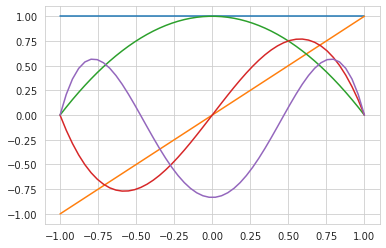

In [10]:
for func in form_poly_system(5):
    plot_function(func, -1, 1)

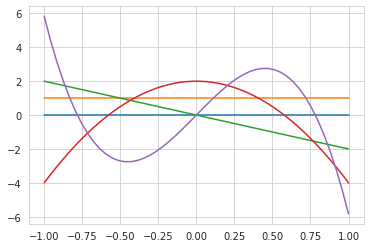

In [11]:
for func in form_poly_system(5):
    X = np.linspace(-1, 1)
    Y = [get_derivative(func)(x) for x in X]
    sns.lineplot(x = X, y = Y)

In [12]:
def get_dot_product(y: Function, z: Function) -> float:
    func = lambda x: y(x) * z(x)
    return integrate.quad(func, -1, 1)[0]

def bilinear_form(y: Function, z: Function) -> float:
    y_der = get_derivative(y)
    z_der = get_derivative(z)
    integral_value = integrate.quad(lambda x: p(x) * y_der(x) * z_der(x) + r(x) * y(x) * z(x), -1, 1)[0]
    Q_l = 0
    if alpha_1 != 0 and alpha_2 != 0:
        Q_l = (alpha_1 / alpha_2) * p(-1) * y(-1) * z(-1)
    Q_r = 0
    if beta_1 != 0 and beta_2 != 0:
        Q_r = (beta_1 / beta_2) * p(1) * y(1) * z(1)
    return integral_value + Q_l + Q_r

In [13]:
def create_linear_combination(coeffs: List[float], funcs: List[Function]) -> Function:
    def inner(x):
        func_values = [func(x) for func in funcs]
        return np.dot(func_values, coeffs)
    return inner

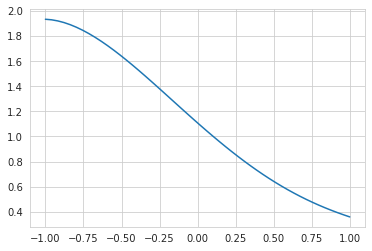

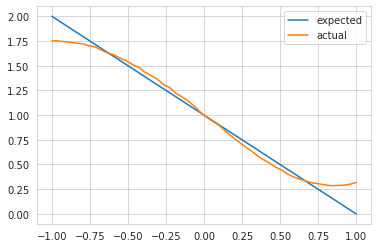

In [41]:
def ritz_method(n: int):
    system = form_poly_system(n)
    S = np.identity(n)
    u = np.zeros(n)
    for i in range(n):
        for j in range(n):
            S[i, j] = bilinear_form(system[i], system[j])
        u[i] = get_dot_product(f, system[i])
    solution = np.linalg.solve(S, u)
    return create_linear_combination(solution, system)

def verify_solution(solution: SimpleFunction, a: float, b: float):
    s_der = get_derivative(solution)
    first_term = get_derivative(lambda x: p(x) * s_der(x))
    left = lambda x: -first_term(x) + r(x) * solution(x)
    right = f

    X = np.linspace(a, b)
    Y_expected = [right(x) for x in X]
    Y_actual = [left(x) for x in X]

    sns.lineplot(x=X, y=Y_expected, label='expected')
    sns.lineplot(x=X, y=Y_actual, label='actual')

func = ritz_method(5)
plot_function(func, -1, 1)
plt.show()

verify_solution(func, -1, 1)
plt.show()

# Тестирование на нескольких N

In [38]:
def get_mean_absolute_error(func: Function, a: float, b: float) -> float:
    X = np.linspace(a, b)
    error = 0
    for x in X:
        error += abs(func(x) - f(x))
    return error / len(X)

def test_method(a: int = -1, b: int = 1, max_N: int = 30):
    errors = []
    for n in trange(1, max_N):
        solution = ritz_method(n)
        s_der = get_derivative(solution)
        first_term = get_derivative(lambda x: p(x) * s_der(x))
        left = lambda x: -first_term(x) + r(x) * solution(x)
        errors.append(get_mean_absolute_error(left, a, b))
    ax = sns.lineplot(x=range(1, max_N), y=errors)
    ax.set(xlabel='N', ylabel='Ошибка')
    plt.show()

100%|██████████| 19/19 [00:03<00:00,  6.23it/s]


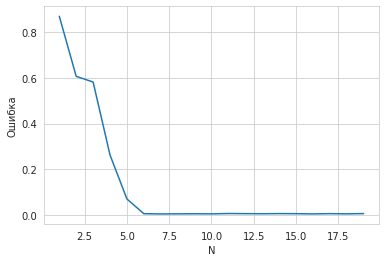

In [39]:
test_method(-1, 1, 20)